# Brain Tumor Detection - 2DModel

# Setup

In [ ]:
%pip install boto3
%pip install nilearn
%pip install focal-loss

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
    
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
import boto3
import os
import cv2
import pandas as pd
import numpy as np
import os.path as op
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from nilearn import image
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from focal_loss import *

In [ ]:
# If running on Google Collab
if not op.exists("/content/DATA"):
  print('downloading data from S3')

  BUCKET_NAME = 'medical-images' 

  # enter authentication credentials
  s3 = boto3.resource('s3', aws_access_key_id = '...', 
                            aws_secret_access_key= '...')

  target = '/content/'
  remoteDirectoryName = 'DATA'
  bucket = s3.Bucket(BUCKET_NAME) 
  for obj in tqdm(bucket.objects.filter(Prefix = remoteDirectoryName)):
      if not os.path.exists(os.path.dirname(obj.key)):
          os.makedirs(os.path.dirname(obj.key))
      bucket.download_file(obj.key, target + obj.key) # save to same path


# Data

In [ ]:
data_paths = np.array([])

# Get the name of each data directory
for dir_name in ['GE3T', 'Singapore', 'Utrecht']:
  data_paths = np.append(data_paths,
                         [os.path.join('/content/DATA/', dir_name, data_number) for data_number in os.listdir(os.path.join('/content/DATA/', dir_name))])

data_paths.shape

(60,)

The following two functions allow respectively to convert a 3D scan into an array of slices with the right dimensions, as well as to remove from the dataset the slices with an empty GT. Especially slices from the neck or the top of the skull rarely contain white matter to be predicted.

In [ ]:
def img_3d_to_2d(lst, img, dim=(224, 224)):
  slices = image.get_data(img)
  
  for i in range(slices.shape[2]):
    lst.append(cv2.resize(slices[:, :, i], dim))

In [ ]:
def remove_empty_mask(flair_lst, t1_lst, mask_lst):
  flair_ret, t1_ret, mask_ret = [], [], []

  for i in range(len(flair_lst)):
    if int(mask_lst[i].max()) != 0:
      flair_ret.append(flair_lst[i])
      t1_ret.append(t1_lst[i])
      mask_ret.append(mask_lst[i])

  return flair_ret, t1_ret, mask_ret

In [ ]:
X = []
X_raw = []
y = []

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

for i in tqdm(range(len(data_paths))):

  data_path = data_paths[i]
  FLAIR_image = image.load_img(os.path.join(data_path, 'pre', 'FLAIR.nii.gz'))
  T1_image = image.load_img(os.path.join(data_path, 'pre', 'T1.nii.gz'))
  GT = image.load_img(os.path.join(data_path, 'wmh.nii.gz'))

  # Remove empty masks
  flair_slices = []
  t1_slices = []
  mask_slices = []
  img_3d_to_2d(flair_slices, FLAIR_image)
  img_3d_to_2d(t1_slices, T1_image)
  img_3d_to_2d(mask_slices, GT)
  flair_slices, t1_slices, mask_slices = remove_empty_mask(flair_slices, t1_slices, mask_slices)

  # Combine slices to make rgb images
  for i in range(len(flair_slices)):
    tophat = cv2.morphologyEx(flair_slices[i], cv2.MORPH_TOPHAT, kernel)

    g = flair_slices[i]
    g = ((g - g.min()) * (1/(g.max() - g.min()) * 255)).astype('uint8')

    b = t1_slices[i]
    b = ((b - b.min()) * (1/(b.max() - b.min()) * 255)).astype('uint8')

    r = tophat
    r = ((r - r.min()) * (1/(r.max() - r.min()) * 255)).astype('uint8')

    mask = mask_slices[i]
    mask = ((mask - mask.min()) * (1/(mask.max() - mask.min()))).astype('float32')

    X.append(np.dstack((r, g, b)))
    X_raw.append(g.reshape((224, 224, 1)))
    y.append(mask.reshape((224, 224, 1)))

X = np.array(X)
X_raw = np.array(X_raw)
y = np.array(y)

In [ ]:
X.shape, y.shape, X_raw.shape

((1326, 224, 224, 3), (1326, 224, 224, 1), (1326, 224, 224, 1))

In [ ]:
y.max(), y.min()

(1.0, 0.0)

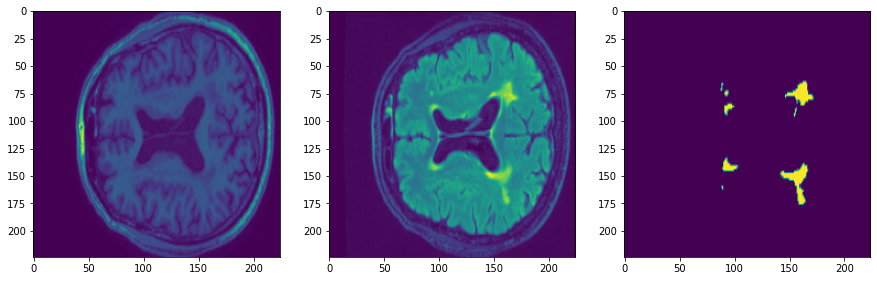

In [ ]:
idx = 100
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(X[idx][:, :, 2])
axs[1].imshow(X_raw[idx].reshape((224, 224)))
axs[2].imshow(y[idx].reshape((224, 224)))

# Model

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f, axis=-1)
    sums = K.sum(y_true_f, axis=-1) + K.sum(y_pred_f, axis=-1)

    return (2. * intersection + smooth) / (sums + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def get_unet(input_size = (224,224,3)):
    # Inspired from Marko Jocic's work
    inputs = Input((input_size[0], input_size[1], input_size[2]))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, f1_m, recall_m])

    return model

# Training without Preprocessing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.33)
X_train.shape, y_train.shape

((888, 224, 224, 1), (888, 224, 224, 1))

In [ ]:
K.clear_session()

model = get_unet(input_size=(224, 224, 1))
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/40
28/28 [==============================] - 47s 1s/step - loss: 0.9862 - dice_coef: 0.0138 - f1_m: 0.0107 - recall_m: 0.9999 - val_loss: 0.9858 - val_dice_coef: 0.0142 - val_f1_m: 0.0121 - val_recall_m: 0.9972
Epoch 2/40
28/28 [==============================] - 25s 901ms/step - loss: 0.9852 - dice_coef: 0.0148 - f1_m: 0.0133 - recall_m: 0.9873 - val_loss: 0.9849 - val_dice_coef: 0.0151 - val_f1_m: 0.0143 - val_recall_m: 0.9676
Epoch 3/40
28/28 [==============================] - 25s 901ms/step - loss: 0.9848 - dice_coef: 0.0152 - f1_m: 0.0148 - recall_m: 0.9599 - val_loss: 0.9841 - val_dice_coef: 0.0159 - val_f1_m: 0.0170 - val_recall_m: 0.9387
Epoch 4/40
28/28 [==============================] - 25s 903ms/step - loss: 0.9830 - dice_coef: 0.0170 - f1_m: 0.0192 - recall_m: 0.9271 - val_loss: 0.9818 - val_dice_coef: 0.0182 - val_f1_m: 0.0258 - val_recall_m: 0.8620
Epoch 5/40
28/28 [==============================] - 25s 897ms/step - loss: 0.9810 - dice_coef: 0.0190 - f1_m: 0.0327 - 

In [ ]:
model.summary()

0.50587326


Text(0.5, 1.0, 'Prediction')

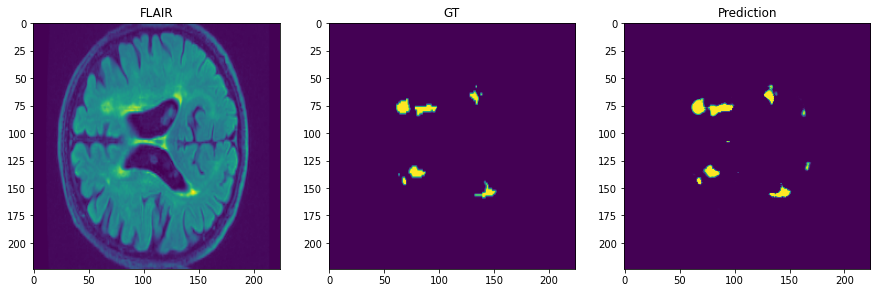

In [ ]:
idx = 135
y_pred = model.predict(X_test[idx:idx+1])

y_true_f = K.flatten(y_test[idx])
y_pred_f = K.flatten(y_pred[0])

print(np.array(dice_coef(model.predict(X_test), y_test)).mean())

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(X_test[idx].reshape(224, 224))
axs[0].set_title('FLAIR')
axs[1].imshow(y_test[idx].reshape(224, 224))
axs[1].set_title('GT')
axs[2].imshow(y_pred[0].reshape(224, 224))
axs[2].set_title('Prediction')

# Training with Preprocessing

The preprocessing used is the conversion into rgb channels of FLAIR, T1 and TOPHAT.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train.shape, y_train.shape

((888, 224, 224, 3), (888, 224, 224, 1))

In [ ]:
K.clear_session()

model_with_pp = get_unet(input_size=(224, 224, 3))
model_with_pp.fit(X_train, y_train, epochs=40, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/40
56/56 [==============================] - 35s 535ms/step - loss: 0.9963 - dice_coef: 0.0037 - f1_m: 0.0034 - recall_m: 0.1561 - val_loss: 0.9870 - val_dice_coef: 0.0130 - val_f1_m: 0.0122 - val_recall_m: 0.8812
Epoch 2/40
56/56 [==============================] - 26s 467ms/step - loss: 0.9854 - dice_coef: 0.0146 - f1_m: 0.0138 - recall_m: 0.9308 - val_loss: 0.9847 - val_dice_coef: 0.0153 - val_f1_m: 0.0172 - val_recall_m: 0.9619
Epoch 3/40
56/56 [==============================] - 26s 468ms/step - loss: 0.9818 - dice_coef: 0.0182 - f1_m: 0.0242 - recall_m: 0.8912 - val_loss: 0.9590 - val_dice_coef: 0.0410 - val_f1_m: 0.0617 - val_recall_m: 0.5784
Epoch 4/40
56/56 [==============================] - 26s 469ms/step - loss: 0.9434 - dice_coef: 0.0566 - f1_m: 0.0873 - recall_m: 0.5732 - val_loss: 0.8738 - val_dice_coef: 0.1262 - val_f1_m: 0.1811 - val_recall_m: 0.5155
Epoch 5/40
56/56 [==============================] - 26s 468ms/step - loss: 0.8080 - dice_coef: 0.1920 - f1_m: 0.3109

0.5305464


Text(0.5, 1.0, 'Prediction')

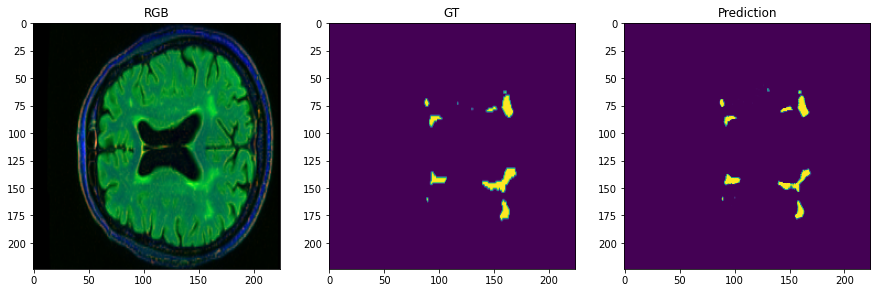

In [ ]:
idx = 50
y_pred = model_with_pp.predict(X_test[idx:idx+1])

y_true_f = K.flatten(y_test[idx])
y_pred_f = K.flatten(y_pred[0])

print(np.array(dice_coef(model_with_pp.predict(X_test), y_test)).mean())


fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(X_test[idx])
axs[0].set_title('RGB')
axs[1].imshow(y_test[idx].reshape(224, 224))
axs[1].set_title('GT')
axs[2].imshow(y_pred[0].reshape(224, 224))
axs[2].set_title('Prediction')